In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import seaborn as sns
import dash
import random

import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output,State

sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv')  
df_analyse.sort_values('date',ascending=True).head()

,date,Australia,China,Denmark,Canada,France,United Kingdom,India
0,2020-01-22,0,548,0,0,0,0,0
1,2020-01-23,0,643,0,0,0,0,0
2,2020-01-24,0,920,0,0,2,0,0
3,2020-01-25,0,1406,0,0,3,0,0
4,2020-01-26,4,2075,0,1,3,0,0


In [3]:

# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #Assume: max susceptible population
beta=0.4   # Assume: infection spread dynamics
gamma=0.1  # Assume: recovery rate


# condition I0+S0+R0=N0
I0=df_analyse.France[35]
S0=N0-I0
R0=0

In [4]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differences) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

# Simulative approach to calculate SIR curves

In [5]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recovered':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

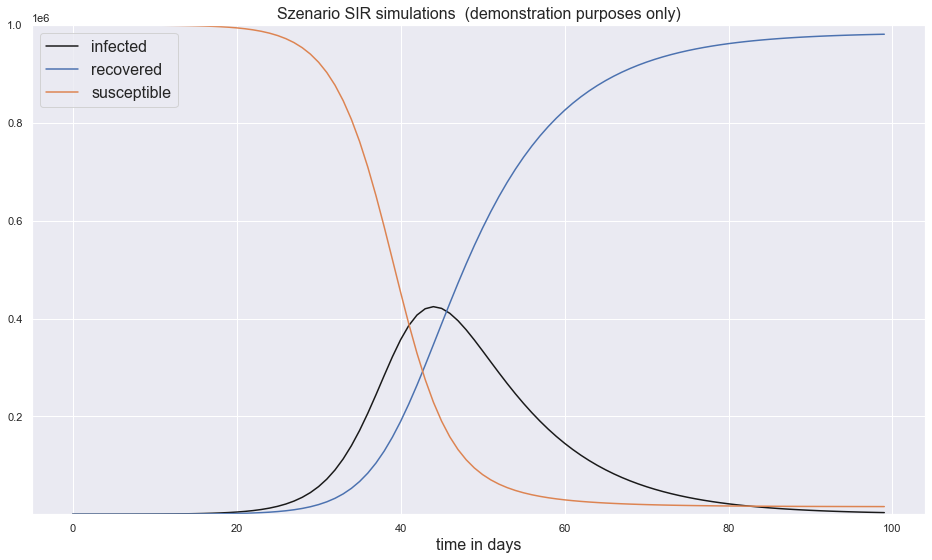

In [6]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting the parameters of SIR model

In [7]:
ydata = np.array(df_analyse.France[35:])
t=np.arange(len(ydata))

In [8]:
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [9]:
def SIR_model_t(SIR,t,beta,gamma):
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [10]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [11]:
# example curve of our differential equationa
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([1.80000000e+01, 2.42972450e+01, 3.27974332e+01, 4.42711073e+01,
       5.97582421e+01, 8.06623850e+01, 1.08877630e+02, 1.46959829e+02,
       1.98357365e+02, 2.67722048e+02, 3.61327663e+02, 4.87632902e+02,
       6.58037546e+02, 8.87896451e+02, 1.19787605e+03, 1.61576323e+03,
       2.17886687e+03, 2.93718697e+03, 3.95756179e+03, 5.32903148e+03,
       7.16966019e+03, 9.63500542e+03, 1.29282558e+04, 1.73116810e+04,
       2.31183077e+04, 3.07614599e+04, 4.07377888e+04, 5.36166346e+04,
       7.00054414e+04, 9.04790002e+04, 1.15462638e+05, 1.45070608e+05,
       1.78924176e+05, 2.16005406e+05, 2.54625180e+05, 2.92570719e+05,
       3.27434113e+05, 3.57033763e+05, 3.79784946e+05, 3.94898455e+05,
       4.02371602e+05, 4.02822407e+05, 3.97256905e+05, 3.86847784e+05,
       3.72766962e+05, 3.56081625e+05, 3.37703772e+05, 3.18376978e+05,
       2.98685155e+05, 2.79072024e+05, 2.59864126e+05, 2.41293328e+05,
       2.23516890e+05, 2.06634447e+05, 1.90701863e+05, 1.75742300e+05,
      

In [12]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

C:\Users\SUHAIL\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-9-c9619b9a0262>:3: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0
<ipython-input-9-c9619b9a0262>:4: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
C:\Users\SUHAIL\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00220873 0.00187201]  start infect: 18
Optimal parameters: beta = 0.10672997300999758  and gamma =  0.033319881903642365


In [13]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

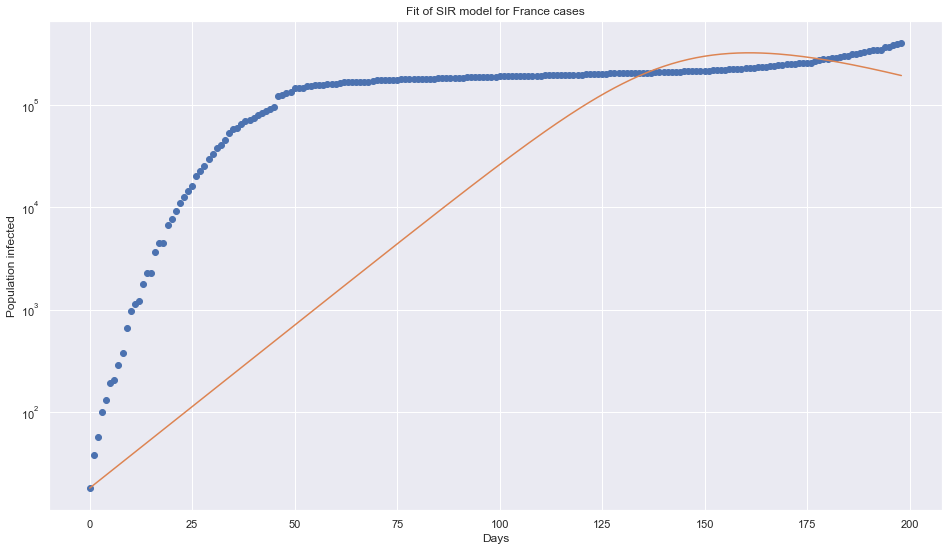

Optimal parameters: beta = 0.10672997300999758  and gamma =  0.033319881903642365
Basic Reproduction Number R0  3.203191815584748
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [14]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for France cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Dynamic beta in SIR (infection rate)

In [15]:
t_initial=28
t_intro_measures=14
t_hold=21
t_relax=21

beta_max=0.4
beta_min=0.11
gamma=0.1
pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))

In [16]:
pd_beta

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.37769231,
       0.35538462, 0.33307692, 0.31076923, 0.28846154, 0.26615385,
       0.24384615, 0.22153846, 0.19923077, 0.17692308, 0.15461538,
       0.13230769, 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.1245    ,
       0.139     , 0.1535    , 0.168     , 0.1825    , 0.197     ,
       0.2115    , 0.226     , 0.2405    , 0.255     , 0.2695 

In [17]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_beta in pd_beta:
   
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

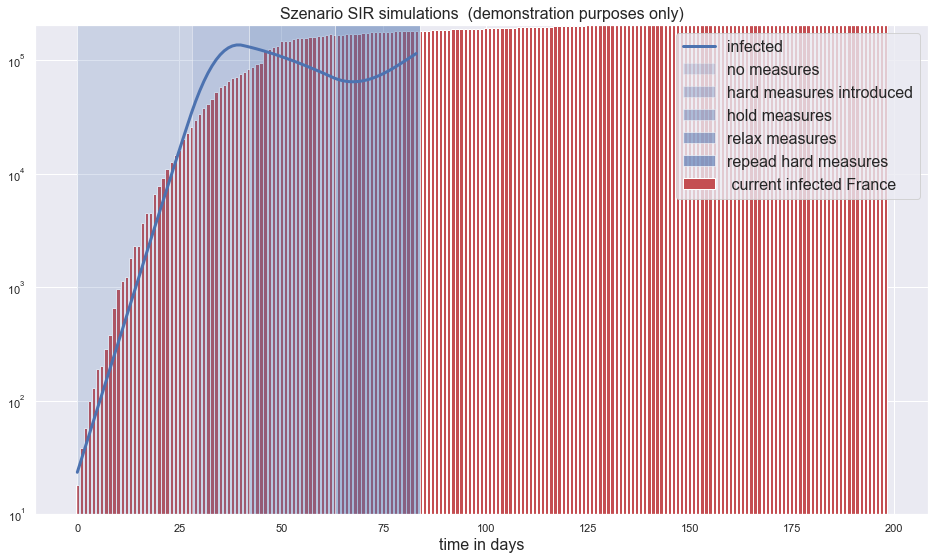

In [18]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()
ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected France',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='repead hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Dynamic Data for whole Data Set

In [19]:
data_path='../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [20]:
pd_raw = pd.read_csv(data_path)
country_list = pd_raw['Country/Region'].unique()
date=pd_raw.columns[4:]
df_analyse=pd.DataFrame({'Date':date})

for each in country_list:
    df_analyse[each] = np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0)).T
df_analyse.to_csv('../data/raw/COVID-19/csse_covid_19_data/SIR.csv',index=False)

df_analyse.sort_values('Date',ascending=True).head()

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
0,1/22/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1/23/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2,1/24/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,1/25/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
4,1/26/20,0,0,0,0,0,0,0,0,4,...,0,0,0,0,2,0,0,0,0,0


In [21]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

df_data=df_analyse[35:]
t=np.arange(df_data.shape[0])
# condition I0+S0+R0=N0

R0=0
for country in df_data.columns[1:]:
    y_data=np.array(df_data[df_data[country]>0][country])
    t=np.arange(len(y_data))
    I0=y_data[0]
    S0=N0-I0
    popt=[0.4,0.1]
    fit_odeint(t, *popt)
    popt, pcov = optimize.curve_fit(fit_odeint, t, y_data, maxfev=5000)
    perr = np.sqrt(np.diag(pcov))
    fitted=fit_odeint(t, *popt)
    fitted_pad = np.concatenate((np.zeros(df_data.shape[0]-len(fitted)) ,fitted))
    df_data[country + '_fitted'] = fitted_pad

df_data = df_data.reset_index(drop=True)
df_data.to_csv('../data/processed/SIR_fitted.csv')
    

C:\Users\SUHAIL\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-9-c9619b9a0262>:3: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0
<ipython-input-9-c9619b9a0262>:4: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-9-c9619b9a0262>:5: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\SUHAIL\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-21-32fc92dc279e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [22]:
color_list = []
for i in range(200):
    var = '#%02x%02x%02x'%(random.randint(0,255),random.randint(0,255),random.randint(0,255))
    color_list.append(var)

In [ ]:
# creating dashboard app containig plotting of source and fitted SIR curve data for whole dataset
fig = go.Figure()
app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  Data Science Project SIR
    
    * This dashboard plots two curves for each country:
    
    The first curve represents the confirmed infected cases along the timeline.
    The second curve represents the simulated infected cases after applying the SIR model along the timeline. 
    
    '''),

    dcc.Markdown('''
    ## Multi-Select Country for visualization
    '''),
    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in df_data.columns[1:200]],
        value=['Germany','France'], # which are pre-selected
        multi=True),
    dcc.Dropdown(
        id='SIR',
        options=[ {'label': 'Susceptable','value':'susceptable'}, {'label': 'Infected','value':'infected'}, {'label': 'Recovered','value':'recovered'},],
        value='confirmed',
        multi=False),
    dcc.Graph(figure=fig, id='main_window_slope')])


@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])
def update_figure(country_list):
    v = 0
    my_yaxis={'type':"log",'title':'Infected people'}
    traces = []
    for each in country_list:
        traces.append(dict(x=df_data['Date'],y=df_data[each],
                                mode='line', line = dict(color = color_list[v]), opacity=1.0,name=each))
        traces.append(dict(x=df_data['Date'],
                                y=df_data[each+'_fitted'],
                                mode='markers',line = dict(color=color_list[v]), opacity=1.0,name=each+'_simulated'))

        v = v+1
    return {
            'data': traces,
            'layout': dict (
                width=1280,height=720,
                xaxis={'title':'Timeline','tickangle':-45,'nticks':20,
                'tickfont':dict(size=14,color="#0c6887"),},yaxis=my_yaxis)}

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Running on http://127.0.0.1:8050/
Debugger PIN: 072-669-437
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
